In [280]:
from keras.preprocessing.image import Iterator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils.np_utils import convert_kernel

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import cv2
import csv
import random
import h5py
from PIL import Image
import random
import os

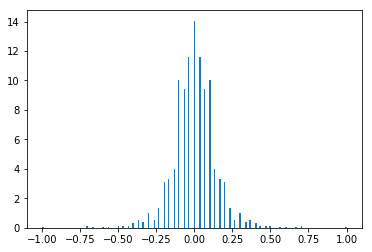

In [284]:
with open('data/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        rows = list(reader)

random.seed(0)
# randomize rows so that validation and training don't have continuous
# parts of the track
random.shuffle(rows)
data = []
# separate out zero steering angle examples, so they can be trimmed
data_zero = []
for row in rows:
    img_pos = row[0].find('IMG')
    filepath = os.path.join('data', row[0][img_pos:])
    steering = float(row[-4])
    # augment the data with a flipped image, reversing the steering as well
    dp = {'img': filepath, 'steering': steering, 'flip': False}
    dp_flip = {'img': filepath, 'steering': -steering, 'flip': True}
    if steering == 0:
        data_zero.extend([dp, dp_flip])
    else:
        data.extend([dp, dp_flip])

num_zero_angles = int(len(data_zero)*.25)
rows = data_zero[:num_zero_angles]+data
random.shuffle(rows)

angles = [row['steering'] for row in rows]

x = plt.hist(angles, bins='auto', normed=True)


-0.2
(100, 320, 3)
(100, 200, 3) 255 0


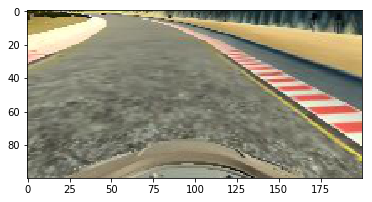

In [259]:
import scipy
from keras.applications.inception_v3 import preprocess_input
#x = np.asarray(x,dtype='float32')
random.shuffle(rows)
rownum = 900
img = scipy.ndimage.imread(rows[rownum][0])

print(rows[rownum][-4])
#img = np.fliplr(img)
img = img[60:, :, :]
print(img.shape)
img = scipy.misc.imresize(img, (100, 200))
#img = scipy.ndimage.gaussian_filter(img, sigma=1)
print(img.shape, np.max(img), np.min(img))
img = img.astype('float32')
img = img/255.0
#img = colors.rgb_to_hsv(img)

plt.imshow(img)